In [1]:
FIRST_YEAR = 2014
LAST_YEAR = 2023

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
import glob
import tqdm.auto as tqdm
import numpy as np
import PIL.Image
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colorbar import Colorbar
import seaborn

from cv2 import resize


Bad key text.latex.preview in file C:\Users\Rignak\AppData\Local\Programs\Python\Python37\Lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\Rignak\AppData\Local\Programs\Python\Python37\Lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\Rignak\AppData\Local\Programs\Python\Python37\Lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig

In [8]:
folders = glob.glob("D:\\MediSAR/KAGGLE-20??/*/*")
folders = [folder for folder in folders if all([filename in os.listdir(folder) for filename in ('owi_wind_speed_256.png', 'unet_wind_speed_256.png', 'era5_wind_speed_256.png')])]
print(f'{len(folders)} folders with wind data')

71488 folders with wind data


In [9]:
discrepancies = [[], []]

wind_array = np.zeros((2, 256, 256), int)
for folder in tqdm.tqdm(folders, smoothing=0.001):
    owi_wind_speed = np.array(PIL.Image.open(folder + '/owi_wind_speed_256.png'))
    dl_wind_speed = np.array(PIL.Image.open(folder + '/unet_wind_speed_256.png'))
    era_wind_speed = np.array(PIL.Image.open(folder + '/era5_wind_speed_256.png'))
    if dl_wind_speed.shape[0] == 1: continue
    if era_wind_speed.shape[0] != dl_wind_speed.shape[0] or era_wind_speed.shape[1] != dl_wind_speed.shape[1]:
        era_wind_speed = resize(era_wind_speed, dl_wind_speed.shape[::-1])
    
    for i, comparison_wind_speed in enumerate((owi_wind_speed, era_wind_speed)):
        validity = np.logical_and(comparison_wind_speed > 0, dl_wind_speed > 0)
        mean_validity = validity.mean()
        comparison_wind_speed = comparison_wind_speed[validity]
        dl_wind_speed_ = dl_wind_speed[validity]

        validity = np.logical_and(comparison_wind_speed < 256, dl_wind_speed_ < 256)
        comparison_wind_speed = comparison_wind_speed[validity]
        dl_wind_speed_ = dl_wind_speed_[validity]

        np.add.at(wind_array[i], (comparison_wind_speed, dl_wind_speed_), np.ones(comparison_wind_speed.shape))
        discrepancies[i].append((abs(comparison_wind_speed/10-dl_wind_speed_/10).mean(), folder, comparison_wind_speed.shape[0], mean_validity))


  0%|          | 0/71488 [00:00<?, ?it/s]

C:\Users\Rignak\AppData\Local\Programs\Python\Python37\Lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


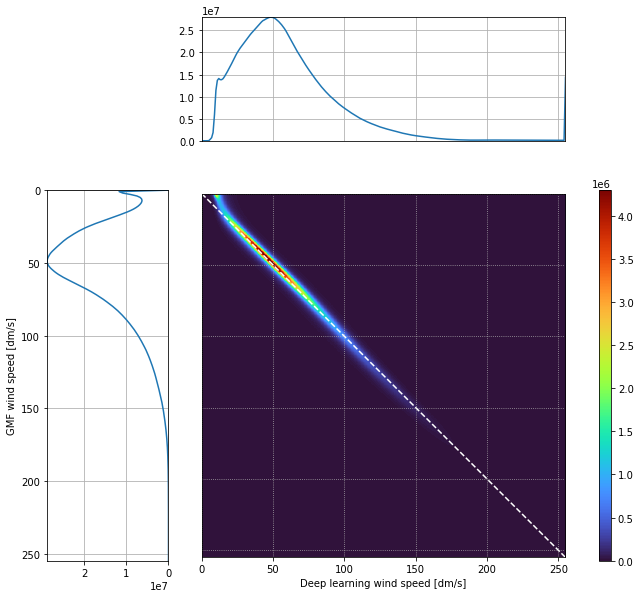

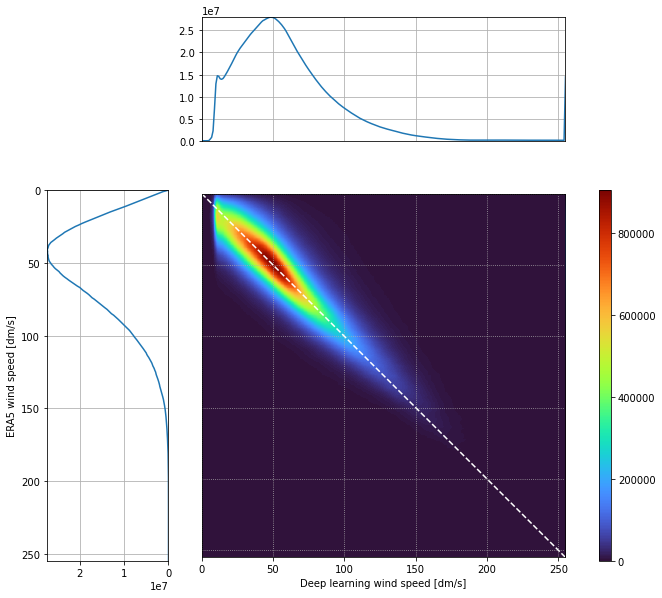

In [10]:
for i, title in enumerate(('GMF', 'ERA5')):
    plt.figure(figsize=(10.1,10), layout="constrained")
    gs = gridspec.GridSpec(2, 3, width_ratios=[1,3,0.1], height_ratios=[1,3])

    ax = plt.subplot(gs[1,1])

    vmax = (wind_array[i] * (1-np.eye(256))).max()
    m = ax.imshow(wind_array[i], vmin=0, vmax=vmax, cmap='turbo')
    ax.plot((0, 256), (0,256), c='white', linestyle='--')
    ax.set_ylim(0,255)
    ax.set_xlim(0,255)
    ax.grid(linestyle='dotted')

    ax1 = plt.subplot(gs[1,0], sharey=ax)
    sumed = np.sum(wind_array[i], axis=1)
    ax1.plot(sumed, range(256))
    ax1.set_ylim(255,0)
    ax1.set_xlim(np.nanpercentile(sumed, 100), 0)
    ax1.grid()

    ax2 = plt.subplot(gs[0,1], sharex=ax)
    sumed = np.sum(wind_array[i], axis=0)
    ax2.plot(range(256), sumed)
    ax2.set_xlim(0,255)
    ax2.set_ylim(0, np.percentile(sumed, 100))
    ax2.grid()


    cb = Colorbar(ax = plt.subplot(gs[1,2]), mappable = m)

    ax1.set_ylabel(f"{title} wind speed [dm/s]")
    ax.set_xlabel("Deep learning wind speed [dm/s]")
    ax2.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    plt.show()
    plt.close()


In [11]:
months = [{
    f'{year}-{month:02}': [[], 0, 0] 
    for year in range(FIRST_YEAR, LAST_YEAR) for month in range(1, 13)
} for i in range(2)]

for i in range(2):
    for mae, folder, surface, mean_validity in discrepancies[i]:
        folder = os.path.split(folder)[1]
        month = folder[4:6]
        year = int(folder[:4])
        month = f'{year}-{month}'

        months[i][month][0].append(mae)
        months[i][month][1] += mae*surface
        months[i][month][2] += surface


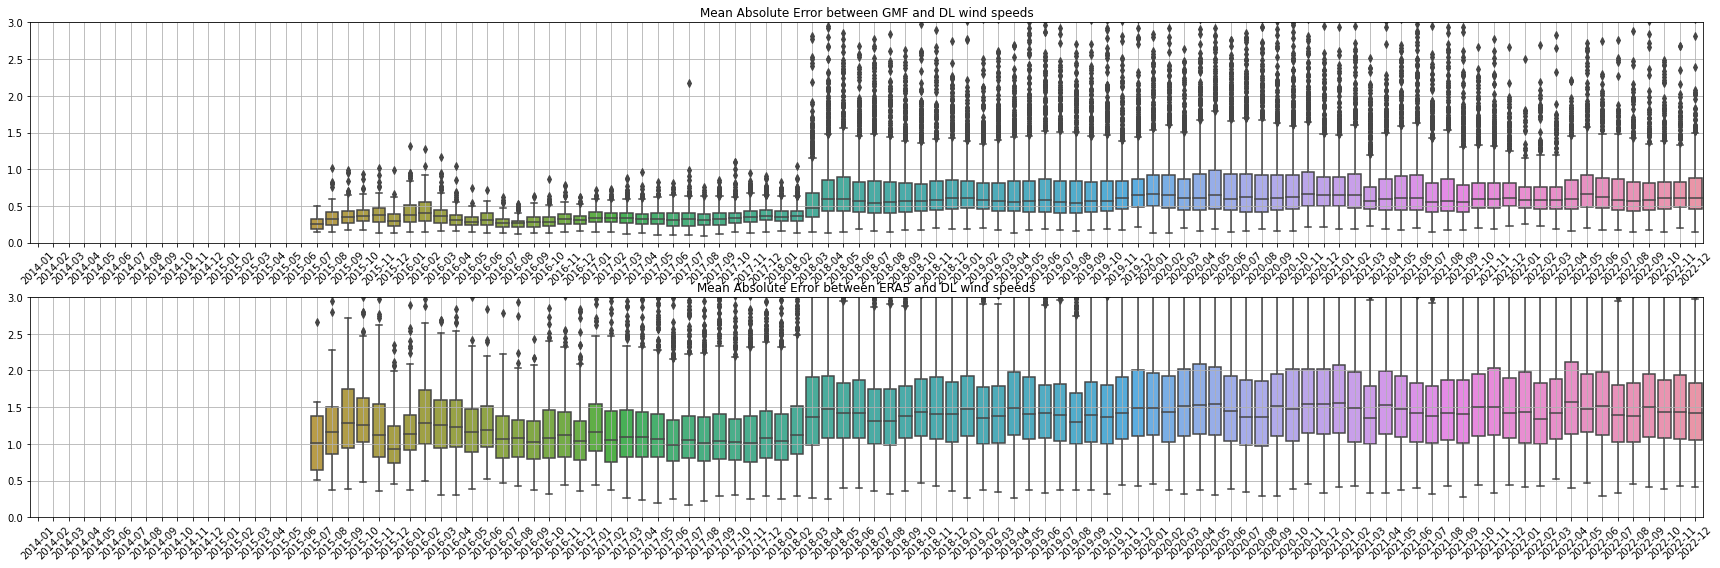

In [14]:
plt.figure(figsize=(24,8))

for i, title in enumerate(['GMF', 'ERA5']):
    plt.subplot(2, 1, i+1)
    xs = range(len(months[i]))
    seaborn.boxplot(data=[e[0] for e in months[i].values()])
    plt.xticks(xs, list(months[i].keys()), rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.ylim(0, 3)
    plt.title(f'Mean Absolute Error between {title} and DL wind speeds')
plt.show()
plt.close()

GMF DISCREPANCIES


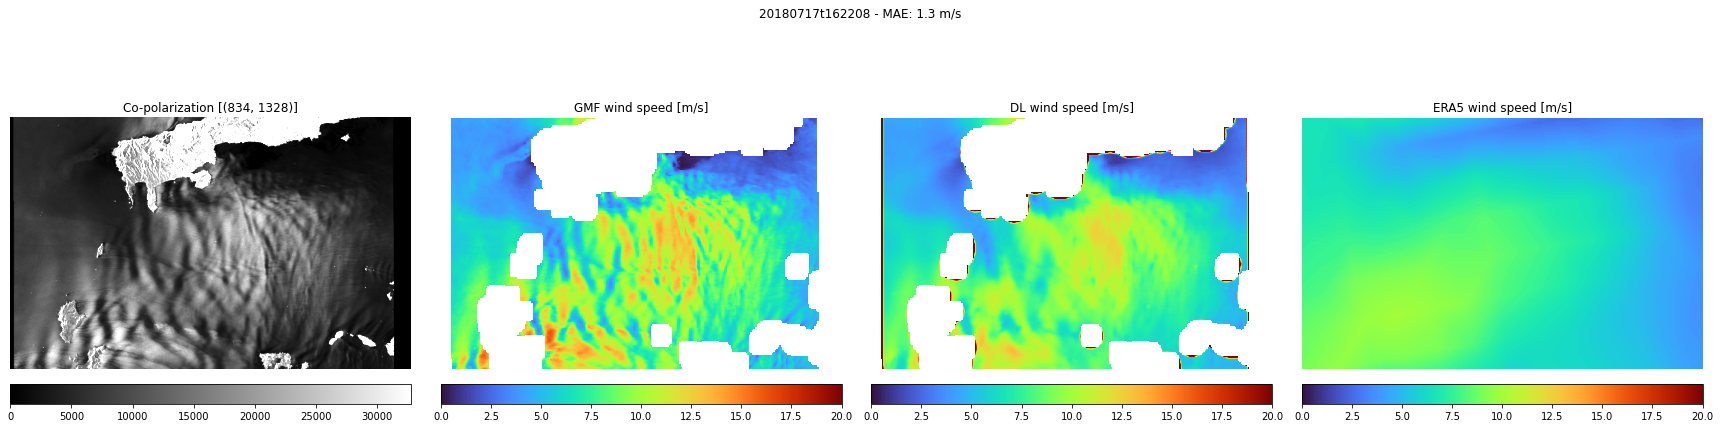

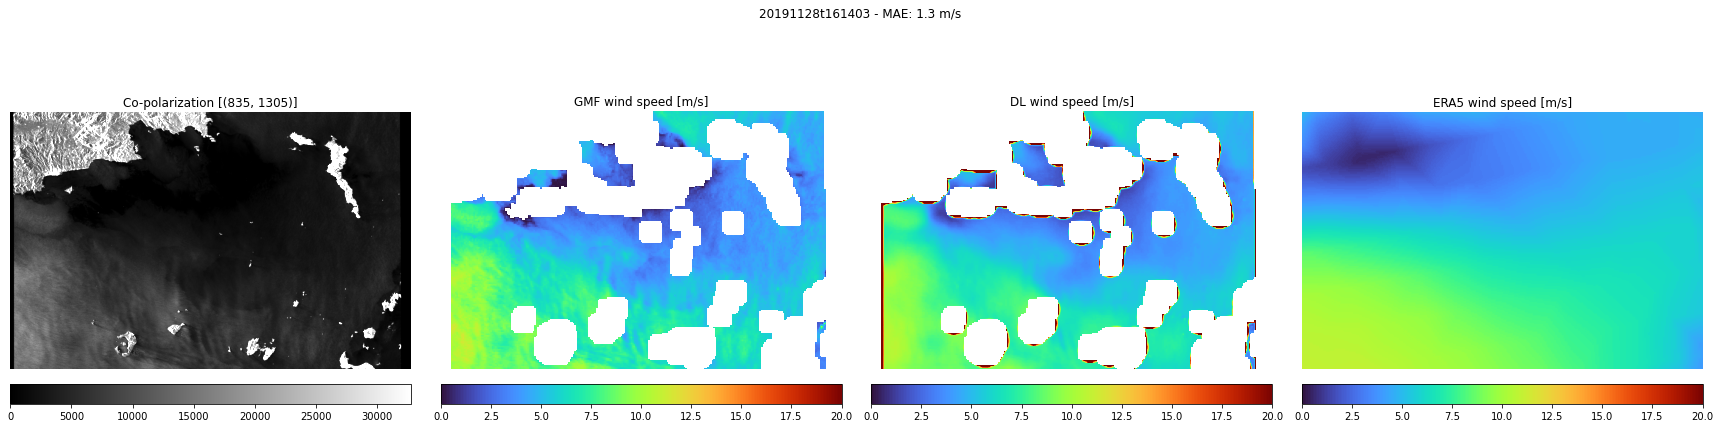

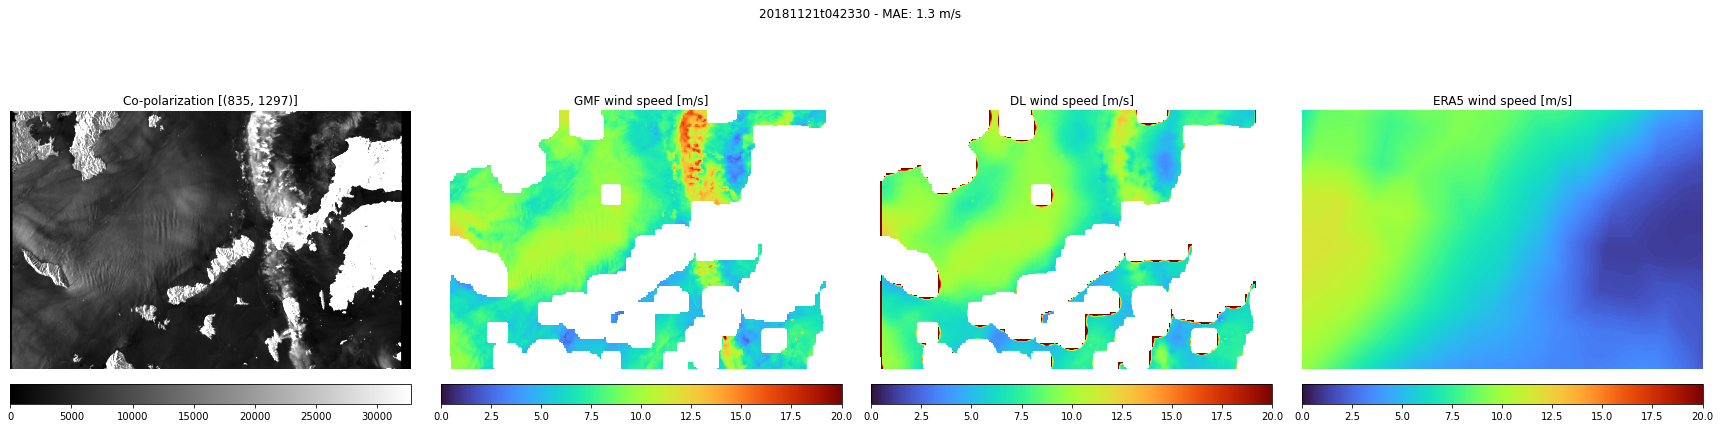

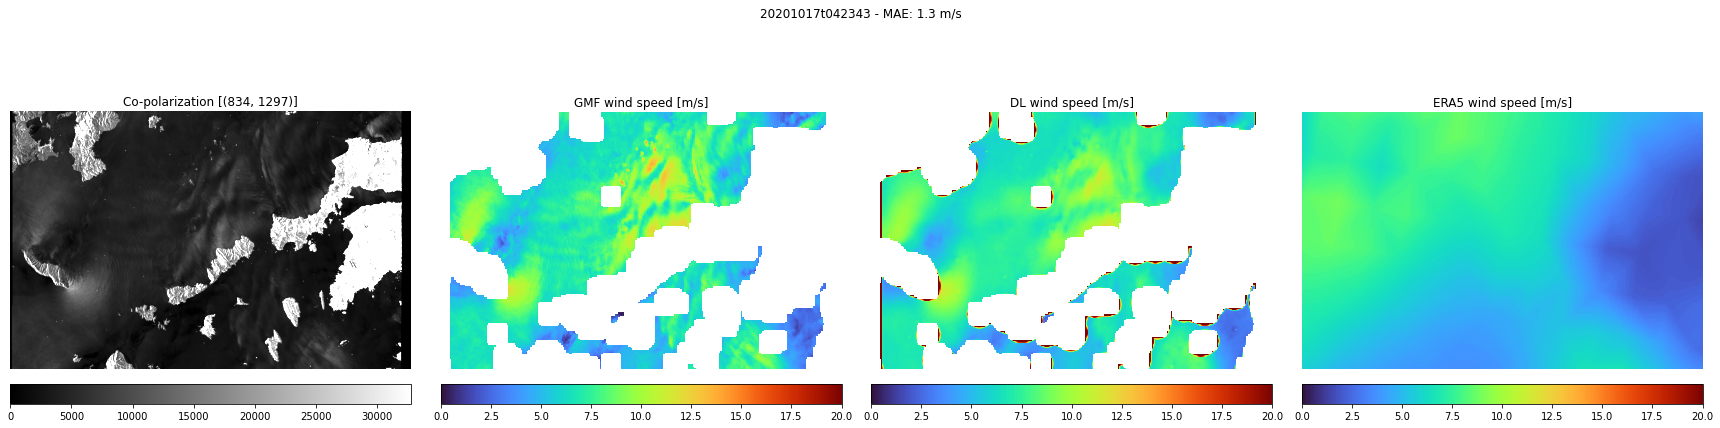

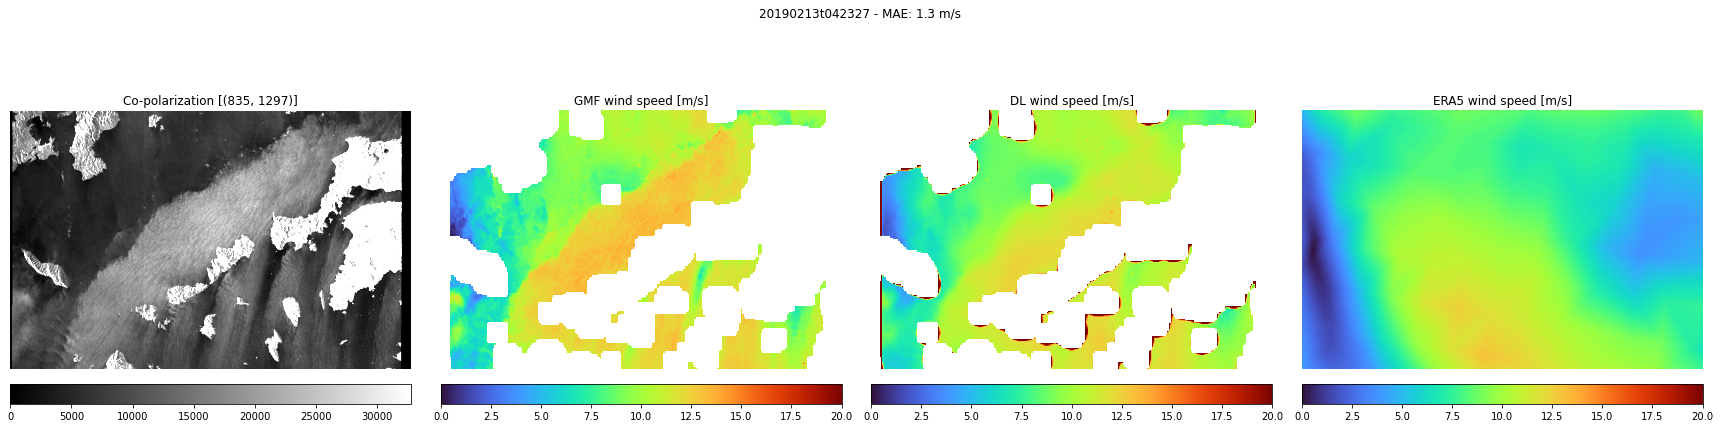

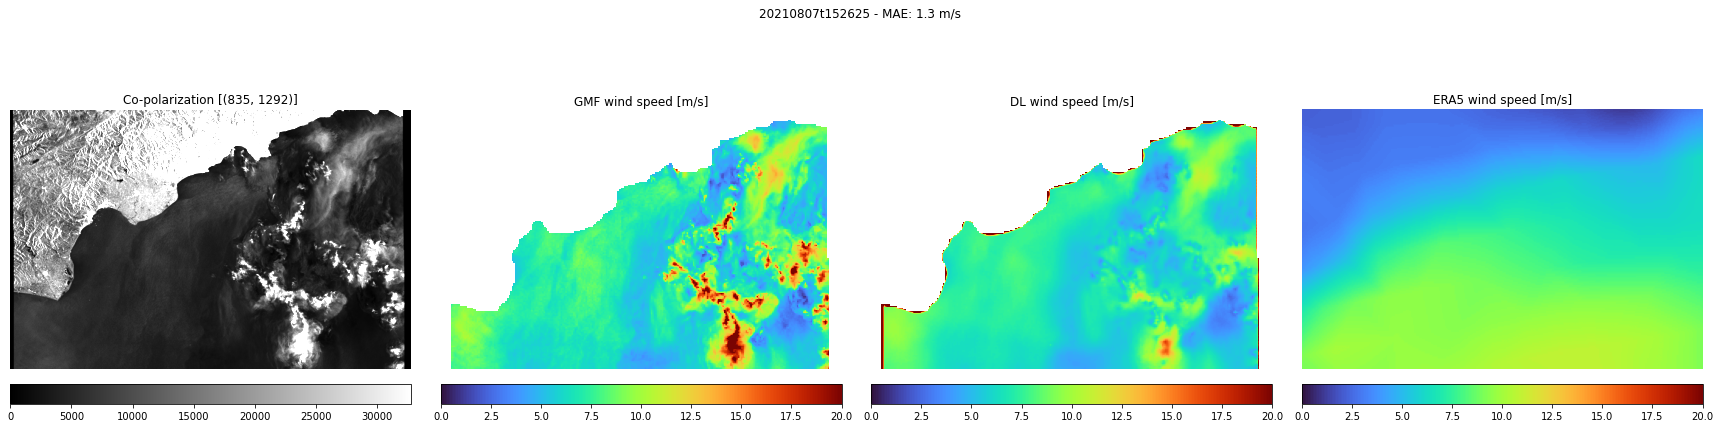

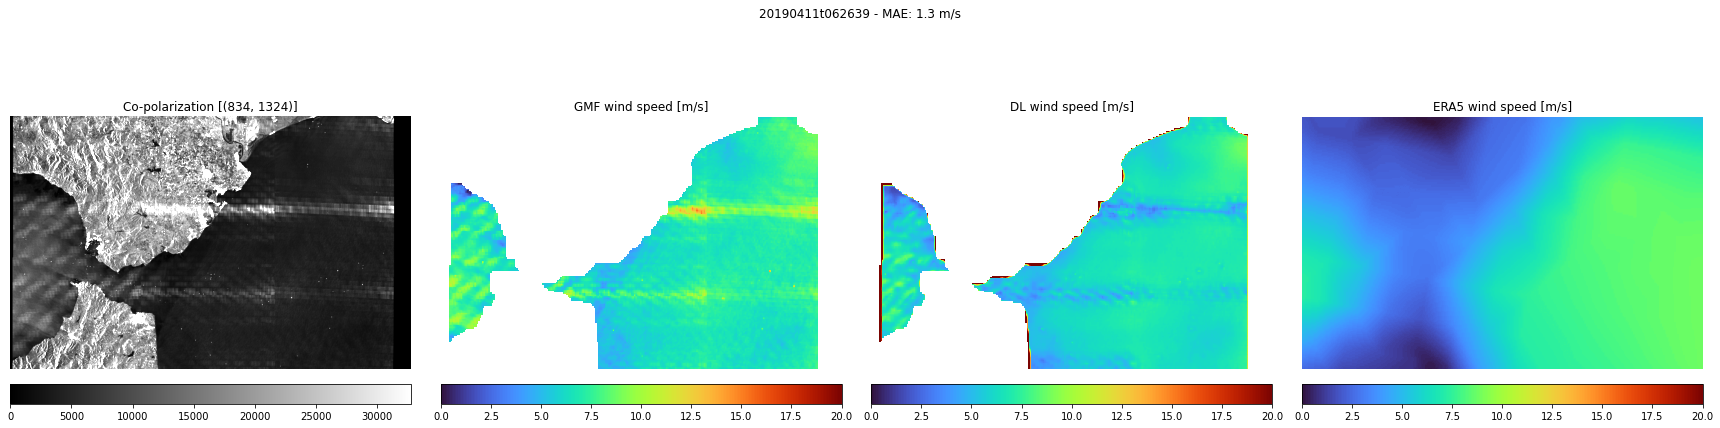

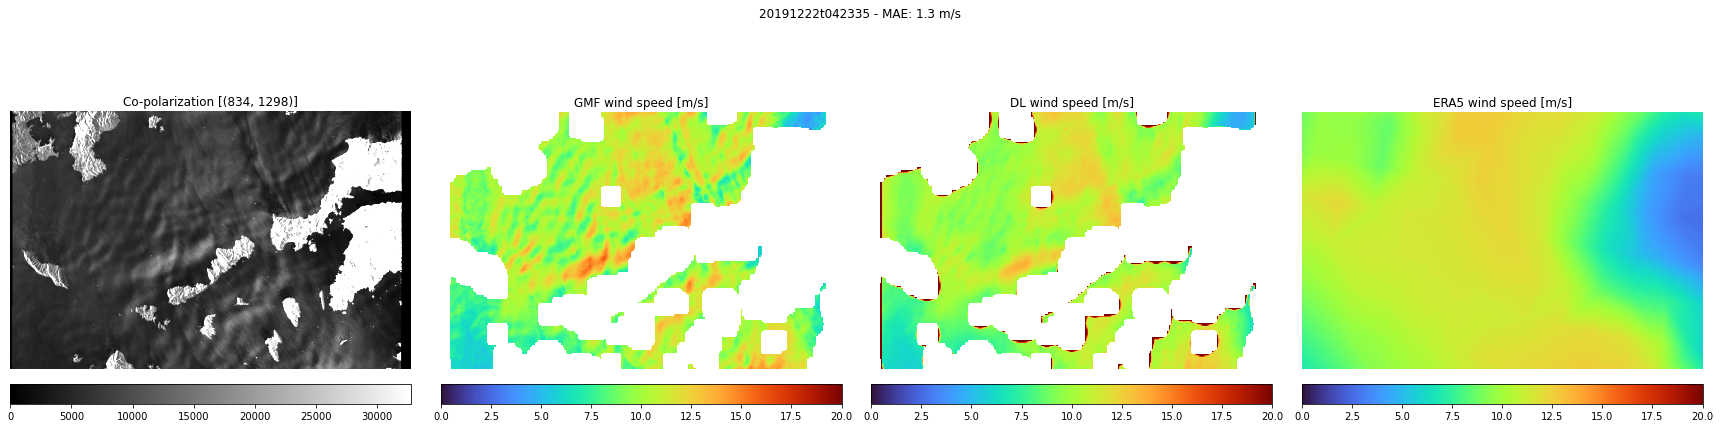

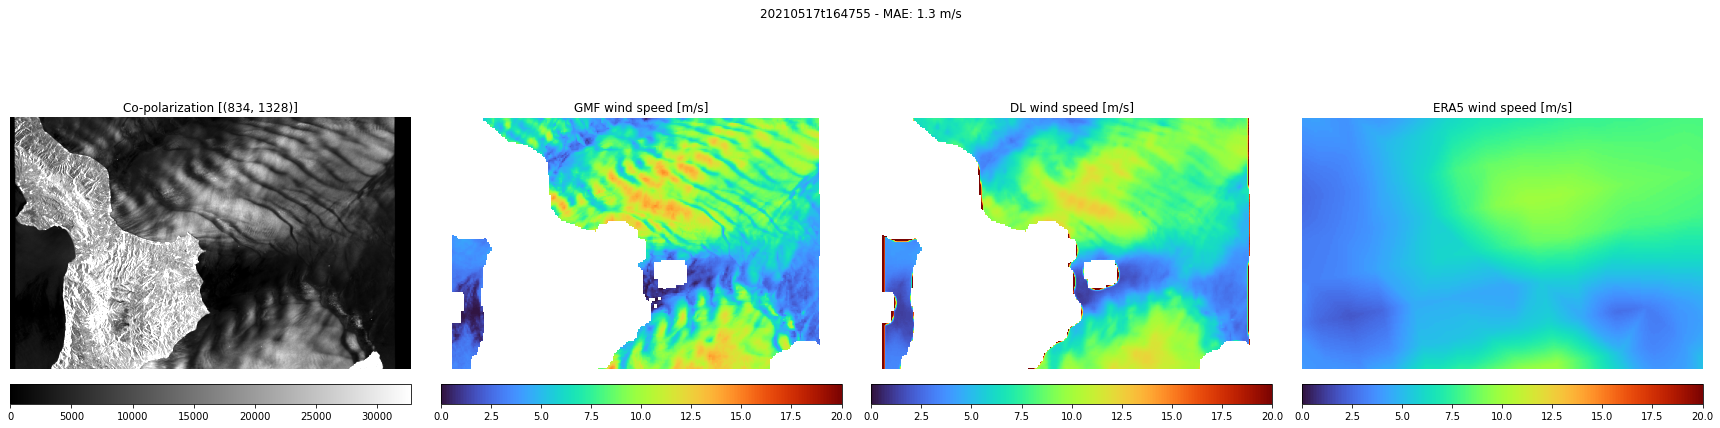

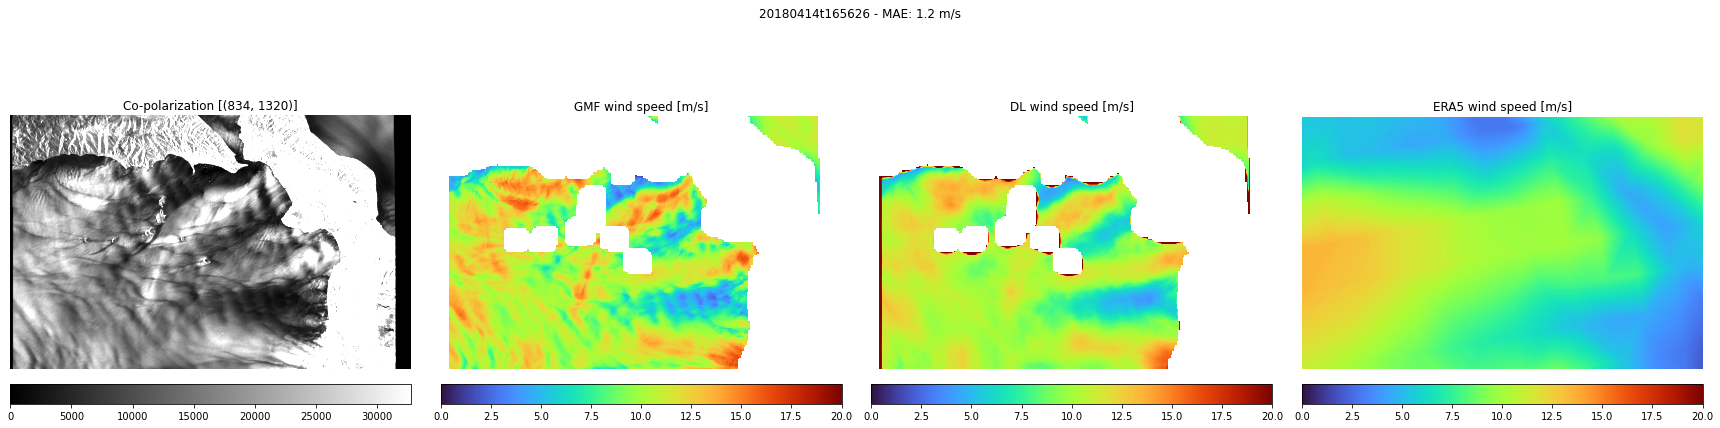

In [15]:
print('GMF DISCREPANCIES')
discrepancies[0] = sorted(discrepancies[0], reverse=True)

k = 0
for mae, folder, surface, mean_validity in discrepancies[0]:
    if k ==10: break
    if mean_validity < 0.5: continue
    iw = np.array(PIL.Image.open(glob.glob(folder + '/*-vv-*')[0]))
    owi_wind_speed = np.array(PIL.Image.open(folder + f'/owi_wind_speed_256.png'))/10
    dl_wind_speed = np.array(PIL.Image.open(folder + '/unet_wind_speed_256.png'))/10
    era5_wind_speed = np.array(PIL.Image.open(folder + '/era5_wind_speed_256.png'))/10
    if np.nanmean(owi_wind_speed) < 3: continue
    k+=1

    plt.figure(figsize=(24,6))
    plt.suptitle(f"{os.path.split(folder)[1]} - MAE: {mae:.1f} m/s")

    plt.subplot(141)
    plt.title(f'Co-polarization [{iw.shape}]')
    plt.imshow(iw, cmap='gray', vmin=0, vmax=2**15)
    plt.colorbar(orientation='horizontal', fraction=0.07, pad=0.04)
    plt.axis('off')

    plt.subplot(142)
    plt.title(f'GMF wind speed [m/s]')
    owi_wind_speed[owi_wind_speed ==0] = np.nan
    plt.imshow(owi_wind_speed, cmap='turbo', vmin=0, vmax=20)
    plt.colorbar(orientation='horizontal', fraction=0.07, pad=0.04)
    plt.axis('off')

    plt.subplot(143)
    plt.title(f'DL wind speed [m/s]')
    dl_wind_speed[dl_wind_speed ==0] = np.nan
    plt.imshow(dl_wind_speed, cmap='turbo', vmin=0, vmax=20)
    plt.colorbar(orientation='horizontal', fraction=0.07, pad=0.04)
    plt.axis('off')

    plt.subplot(144)
    plt.title(f'ERA5 wind speed [m/s]')
    dl_wind_speed[dl_wind_speed ==0] = np.nan
    plt.imshow(era5_wind_speed, cmap='turbo', vmin=0, vmax=20)
    plt.colorbar(orientation='horizontal', fraction=0.07, pad=0.04)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()